# Import packages

In [3]:
import numpy as np
import pandas as pd
import sqlite3
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset and data cleaning

In [4]:
conn = sqlite3.connect("../db/stocks.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('growth_stock',), ('value_stock',), ('inflation_5yr',), ('exchange',), ('CPI',), ('leverage',), ('spending',), ('GDP',), ('treasury_10yr',)]


In [5]:
# select the actual values of what we are interested in, with their de-trending version of daily differences 
cmd = '''
SELECT g.Date AS Date,
        g."Adj Close" AS GrowthStock_AdjClose,
        (g."Adj Close" - LAG(g."Adj Close", 1) OVER (ORDER BY g.Date))/ 
                LAG(g."Adj Close", 1) OVER (ORDER BY g.Date) AS GrowthStock_PercentChange,
        
        v."Adj Close" AS ValueStock_AdjClose,
        (v."Adj Close" - LAG(v."Adj Close", 1) OVER (ORDER BY v.Date))/ 
                LAG(v."Adj Close", 1) OVER (ORDER BY v.Date) AS ValueStock_PercentChange,
        
        t."Adj Close" AS Treasury10yr_AdjClose,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date))/ 
                LAG(t."Adj Close", 1) OVER (ORDER BY t.Date) AS Treasury10yr_PercentChange,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date)) AS Treasury10yr_Diff,
        
        e.DEXCAUS AS exchange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date))/ 
                LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date) AS exchange_PercentChange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date)) AS exchange_Diff,
        
        i.T5YIE AS inflation5yr,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY i.Date))/ 
                LAG(i.T5YIE, 1) OVER (ORDER BY i.Date) AS inflation5yr_PercentChange,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY i.Date)) AS inflation5yr_Diff,
        
        c.CPIAUCSL_PC1 AS CPI,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date))/ 
                LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date) AS CPI_PercentChange,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date)) AS CPI_Diff
        
FROM growth_stock g
LEFT JOIN value_stock v
ON g.Date = v.Date
LEFT JOIN treasury_10yr t
ON g.Date = t.Date
LEFT JOIN exchange e
ON g.Date = e.Date
LEFT JOIN inflation_5yr i
ON g.Date = i.Date
LEFT JOIN CPI c
ON g.Date = c.Date
'''

df = pd.read_sql_query(cmd, conn)
df.head()

,Date,GrowthStock_AdjClose,GrowthStock_PercentChange,ValueStock_AdjClose,ValueStock_PercentChange,Treasury10yr_AdjClose,Treasury10yr_PercentChange,Treasury10yr_Diff,exchange,exchange_PercentChange,exchange_Diff,inflation5yr,inflation5yr_PercentChange,inflation5yr_Diff,CPI,CPI_PercentChange,CPI_Diff
0,2000-05-26,15.213005,NaN,36.438076,NaN,6.320,NaN,NaN,1.5045,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
1,2000-05-30,15.844181,0.041489,36.994823,0.015279,6.367,0.007437,0.047,1.5036,-0.000598,-0.0009,None,NaN,NaN,NaN,NaN,NaN
2,2000-05-31,15.806020,-0.002409,37.273205,0.007525,6.285,-0.012879,-0.082,1.4977,-0.003924,-0.0059,None,NaN,NaN,NaN,NaN,NaN
3,2000-06-01,16.040890,0.014860,37.733952,0.012361,6.195,-0.014320,-0.090,1.4910,-0.004474,-0.0067,None,NaN,NaN,3.73494,NaN,NaN
4,2000-06-02,16.569317,0.032942,38.261909,0.013992,6.148,-0.007587,-0.047,1.4785,-0.008384,-0.0125,None,NaN,NaN,NaN,NaN,NaN


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.isna().sum()

Date                             0
GrowthStock_AdjClose             0
GrowthStock_PercentChange        1
ValueStock_AdjClose              0
ValueStock_PercentChange         1
Treasury10yr_AdjClose            7
Treasury10yr_PercentChange      13
Treasury10yr_Diff               13
exchange                         1
exchange_PercentChange          53
exchange_Diff                    2
inflation5yr                   651
inflation5yr_PercentChange     689
inflation5yr_Diff              652
CPI                           5294
CPI_PercentChange             5295
CPI_Diff                      5295
dtype: int64

In [8]:
# # code to fill NA values
# #since linear regressions have independent assumptions, we eventually decide not to include it
# df['CPI'] = df.CPI.fillna(method = 'ffill', limit = 30)
# df['CPI_PercentChange'] = df.CPI_PercentChange.fillna(method = 'ffill', limit = 30)
# df['CPI_Diff'] = df.CPI_Diff.fillna(method = 'ffill', limit = 30)

# df.isna().sum()

In [9]:
df = df.dropna()

# EDA and Visualizations

In [10]:
def compare_indices(data, col_A, col_B):
    # function to plot line plots and histograms for any two pairs of values
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.lineplot(ax=axes[0], data=data, x='Date', y=col_A, alpha = 0.6, label = col_A.split('_')[0])
    sns.lineplot(ax=axes[0], data=data, x='Date', y=col_B, alpha = 0.6, label = col_B.split('_')[0])
#     plt.legend()
    sns.scatterplot(ax=axes[1], x = col_A, y = col_B, size = 0.1, data = data)
    return fig, axes

Text(0, 0.5, '% Change')

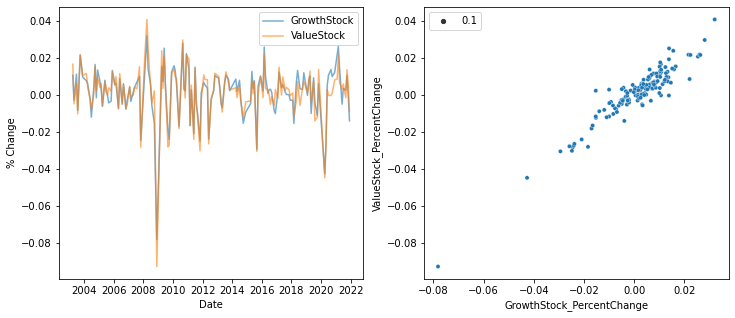

In [12]:
fig, axes = compare_indices(df, 'GrowthStock_PercentChange', 'ValueStock_PercentChange')
axes[0].set_ylabel('% Change')

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='Date', ylabel='GrowthStock_PercentChange'>,
        <AxesSubplot:xlabel='GrowthStock_PercentChange', ylabel='Treasury10yr_PercentChange'>],
       dtype=object))

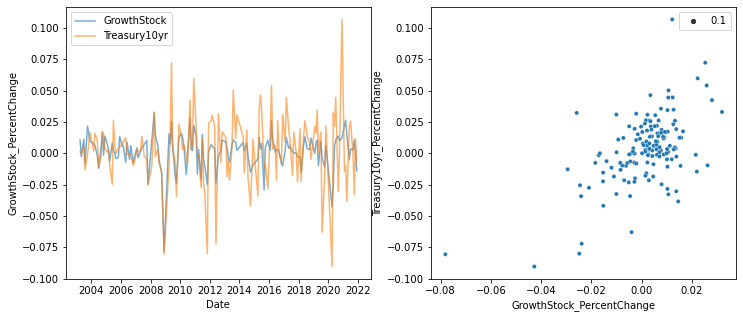

In [11]:
compare_indices(df, 'GrowthStock_PercentChange', 'Treasury10yr_PercentChange')

# Modeling

## Simple Linear Regressions

In [18]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence

/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Growth Stock vs Treasure 10 year percentage change

In [19]:
X = df.Treasury10yr_PercentChange
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

# use cooks distance to remove outliers
cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1) 

In [20]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.328
Model:                                   OLS   Adj. R-squared:                  0.323
Method:                        Least Squares   F-statistic:                     65.80
Date:                       Tue, 08 Mar 2022   Prob (F-statistic):           2.71e-13
Time:                               22:44:26   Log-Likelihood:                 453.99
No. Observations:                        137   AIC:                            -904.0
Df Residuals:                            135   BIC:                            -898.1
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0011      0.001      1.476      0.142      -0.000       0.003
Treasury10yr_PercentChange     0.2800      0.035      8.112      0.000       0.212       0.348
==============================================================================
Omnibus:                        3.283   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                3.581
Skew:                           0.063   Prob(JB):                        0.167
Kurtosis:                       3.782   Cond. No.                         45.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

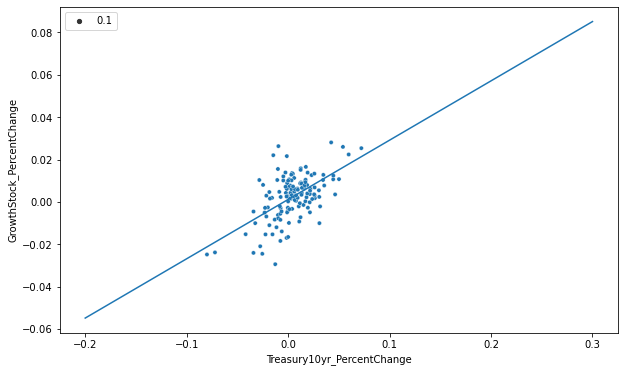

In [22]:
plt.figure(figsize = (10,6))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.1,
                data = df)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

### Growth Stock vs Treasure 10 year diff

In [23]:
X = df.Treasury10yr_Diff
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

#detect outliers removal 
cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1)

In [24]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.337
Model:                                   OLS   Adj. R-squared:                  0.332
Method:                        Least Squares   F-statistic:                     68.56
Date:                       Tue, 08 Mar 2022   Prob (F-statistic):           1.06e-13
Time:                               22:44:26   Log-Likelihood:                 457.75
No. Observations:                        137   AIC:                            -911.5
Df Residuals:                            135   BIC:                            -905.7
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0013      0.001      1.772      0.079      -0.000       0.003
Treasury10yr_Diff     0.1186      0.014      8.280      0.000       0.090       0.147
==============================================================================
Omnibus:                        4.188   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                5.182
Skew:                           0.082   Prob(JB):                       0.0750
Kurtosis:                       3.938   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

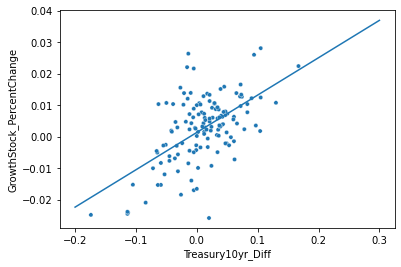

In [26]:
plt.figure(figsize = (6,4))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.01,
                data = df,
               legend = False)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

Simple linear regression gives a base line accuracy of 33%.

## Other machine learning models

In [27]:
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

X = df[["Treasury10yr_PercentChange", "exchange_PercentChange", "inflation5yr_PercentChange", "CPI_PercentChange"]]
y = df[["GrowthStock_PercentChange", "ValueStock_PercentChange"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 16, test_size = 0.3)
train_y1 = train_y["GrowthStock_PercentChange"]
train_y2 = train_y["ValueStock_PercentChange"]
test_y1 = test_y["GrowthStock_PercentChange"]
test_y2 = test_y["ValueStock_PercentChange"]

## Multiple Linear regression

### Growth Stock

In [28]:
lm1 = LinearRegression()
cv = cross_val_score(lm1, train_X, train_y1, scoring = 'neg_mean_squared_error')
print(np.mean(-cv))

0.00021159340507463705


In [29]:
lm1.fit(train_X, train_y1)
print("Training Score: ", lm1.score(train_X, train_y1))
predictions = lm1.predict(test_X)
print("R^2 Score: {}".format(r2_score(test_y1, predictions)))
print("MSE: {}".format(mean_squared_error(test_y1, predictions)))

Training Score:  0.4639972494829715
R^2 Score: 0.47069731225468303
MSE: 7.623666221415398e-05


In [52]:
#coefficient for each variable
lm1.coef_

array([ 0.22470925, -0.08249631,  0.06293106,  0.00071093])

### Value Stock

In [30]:
lm2 = LinearRegression()
cv = cross_val_score(lm2, train_X, train_y2, scoring = 'neg_mean_squared_error')
print(np.mean(-cv))

0.00019314110338170868


In [31]:
lm2.fit(train_X, train_y1)
print("Training Score: ", lm2.score(train_X, train_y2))
predictions = lm2.predict(test_X)
print("R^2 Score: {}".format(r2_score(test_y2, predictions)))
print("MSE: {}".format(mean_squared_error(test_y2, predictions)))

Training Score:  0.5385799995747356
R^2 Score: 0.43163966319887404
MSE: 0.0001049028023981924


In [54]:
lm2.coef_

array([ 0.22470925, -0.08249631,  0.06293106,  0.00071093])

## Random Forest Regressor

### Growth Stock

In [32]:
#model init
rf1 = RandomForestRegressor(n_estimators=100, 
                           random_state = 2, 
                           min_samples_split=3, 
                           max_depth = 3)
#cross validation
cv = cross_val_score(rf1, train_X, train_y1, scoring = 'neg_mean_squared_error')
print(np.mean(-cv))

0.00015657601744187277


In [33]:
rf1.fit(train_X, train_y1)
print("Training Score: ", rf1.score(train_X, train_y1))
predictions = rf1.predict(test_X)
print("R^2 Score: {}".format(r2_score(test_y1, predictions)))
print("MSE: {}".format(mean_squared_error(test_y1, predictions)))

Training Score:  0.6419461931142347
R^2 Score: 0.3600090464688751
MSE: 9.217934326444078e-05


/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

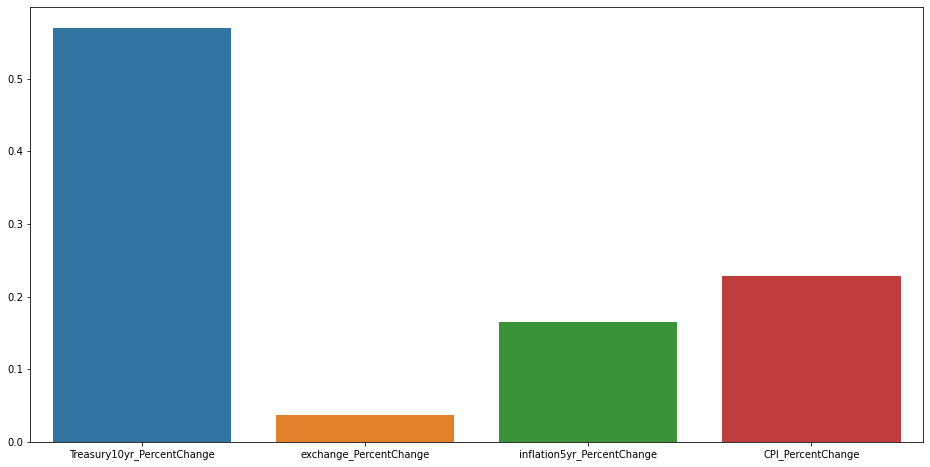

In [34]:
#importance based on r2
plt.figure(figsize = (16,8))
sns.barplot(train_X.columns, rf1.feature_importances_)

/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

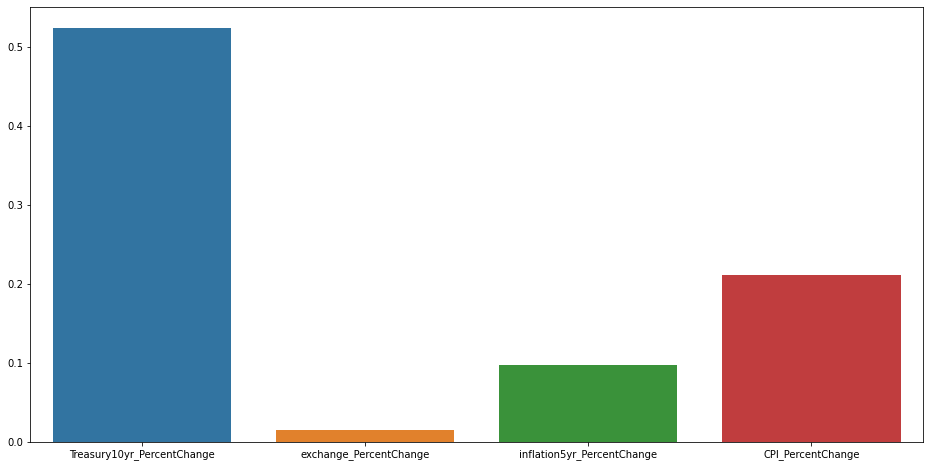

In [35]:
#permutation importance
plt.figure(figsize = (16,8))
sns.barplot(train_X.columns, permutation_importance(rf1, train_X, train_y1)['importances_mean'])

[Text(0.4, 0.875, 'inflation5yr_PercentChange <= -0.48\nsquared_error = 0.0\nsamples = 66\nvalue = 0.003'),
 Text(0.2, 0.625, 'squared_error = 0.0\nsamples = 1\nvalue = -0.078'),
 Text(0.6, 0.625, 'Treasury10yr_PercentChange <= 0.039\nsquared_error = 0.0\nsamples = 65\nvalue = 0.004'),
 Text(0.4, 0.375, 'CPI_PercentChange <= 0.305\nsquared_error = 0.0\nsamples = 63\nvalue = 0.003'),
 Text(0.2, 0.125, 'squared_error = 0.0\nsamples = 52\nvalue = 0.001'),
 Text(0.6, 0.125, 'squared_error = 0.0\nsamples = 11\nvalue = 0.011'),
 Text(0.8, 0.375, 'squared_error = 0.0\nsamples = 2\nvalue = 0.026')]

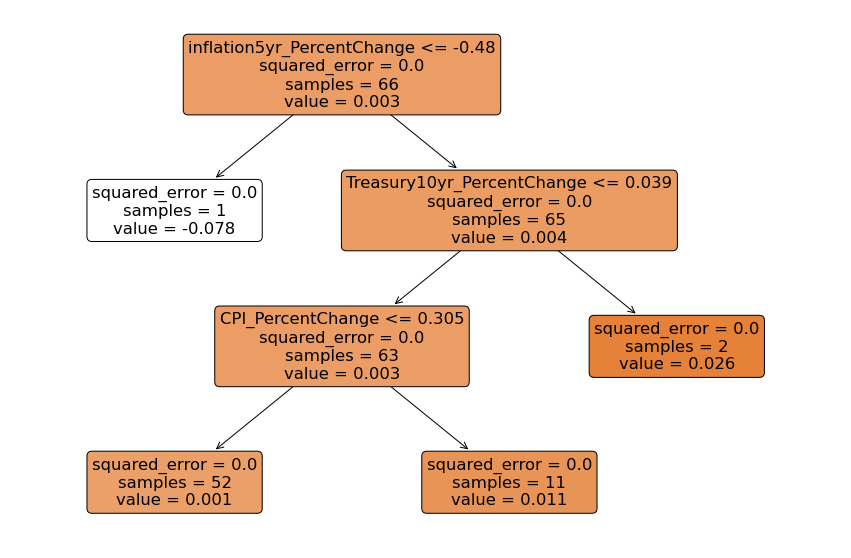

In [70]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf1.estimators_[2], 
          feature_names=train_X.columns,
          class_names=train_y1.name, 
          filled=True, 
          impurity=True, 
          rounded=True)

### Value Stock

In [36]:
#model init
rf2 = RandomForestRegressor(n_estimators=100, 
                           random_state = 2, 
                           min_samples_split=3, 
                           max_depth = 3)
#cross validation 
cv = cross_val_score(rf2, train_X, train_y2, scoring = 'neg_mean_squared_error')
print(np.mean(-cv))

0.0001604205003123889


In [37]:
rf2.fit(train_X, train_y2)
print("Training Score: ", rf1.score(train_X, train_y2))
predictions = rf2.predict(test_X)
print("R^2 Score: {}".format(r2_score(test_y2, predictions)))
print("MSE: {}".format(mean_squared_error(test_y2, predictions)))

Training Score:  0.6341355194003865
R^2 Score: 0.34193175651621355
MSE: 0.0001214602751825388


/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

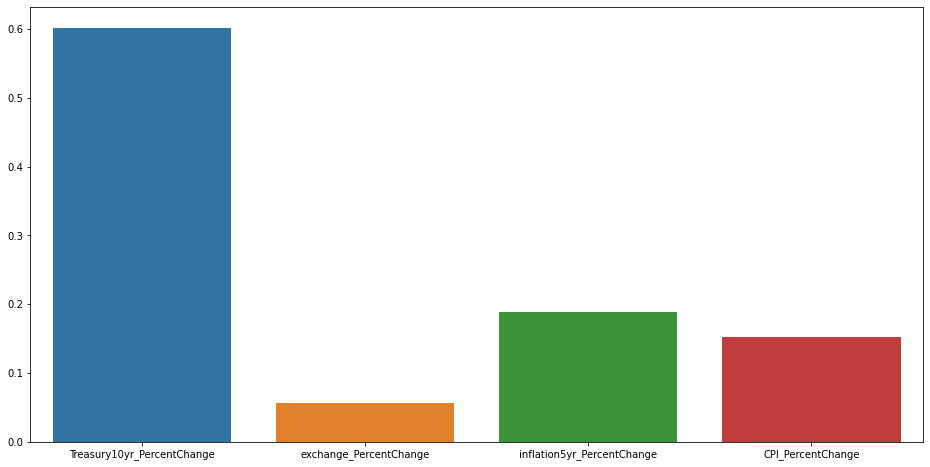

In [38]:
#importance based on r2
plt.figure(figsize = (16,8))
sns.barplot(train_X.columns, rf2.feature_importances_)

/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

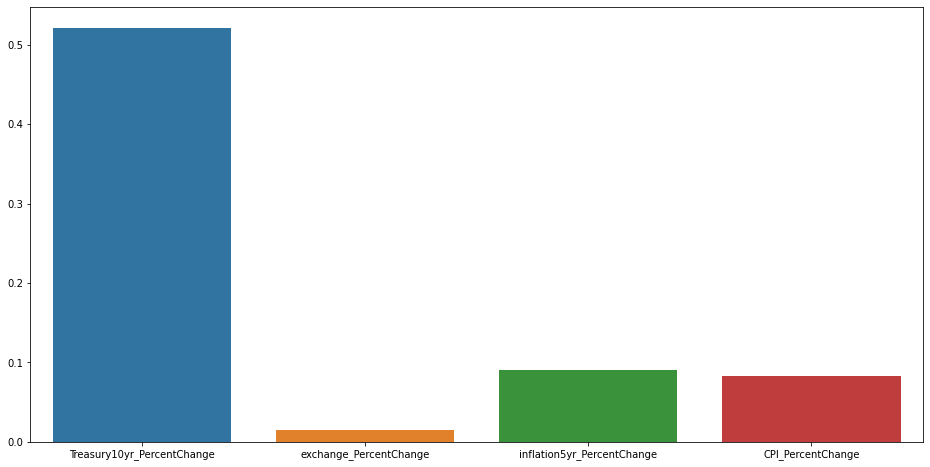

In [39]:
#permutation importance
plt.figure(figsize = (16,8))
sns.barplot(train_X.columns, permutation_importance(rf2, train_X, train_y2)['importances_mean'])

## Extreme Gradient Boosting

### Growth Stock

In [40]:
#model init
xgb1 = GradientBoostingRegressor(n_estimators=100, 
                                random_state = 2, 
                                min_impurity_decrease=0.0001, 
                                min_samples_split=2, 
                                max_depth = 2)
#cross validation score 
cv = cross_val_score(xgb1, train_X, train_y1, scoring = 'neg_mean_squared_error')
print(np.mean(-cv))

0.00015559359569579693


In [41]:
xgb1.fit(train_X, train_y1)
print("Training Score: ", xgb1.score(train_X, train_y1))
predictions = xgb1.predict(test_X)
print("R^2 Score: {}".format(r2_score(test_y1, predictions)))
print("MSE: {}".format(mean_squared_error(test_y1, predictions)))

Training Score:  0.7646394376499219
R^2 Score: 0.38733735196510477
MSE: 8.82431856683476e-05


/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Treasury10yr_PercentChange'),
  Text(1, 0, 'exchange_PercentChange'),
  Text(2, 0, 'inflation5yr_PercentChange'),
  Text(3, 0, 'CPI_PercentChange')])

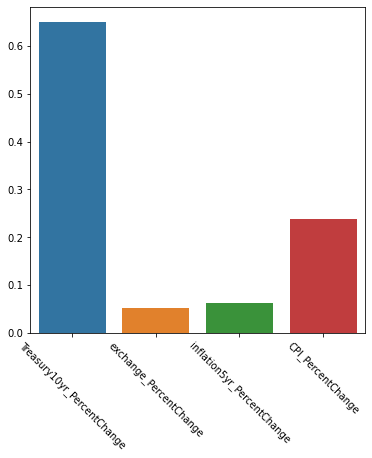

In [51]:
#importance based on r2
plt.figure(figsize = (6,6))
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
sns.barplot(train_X.columns, xgb1.feature_importances_)
plt.xticks(rotation = -45)

/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

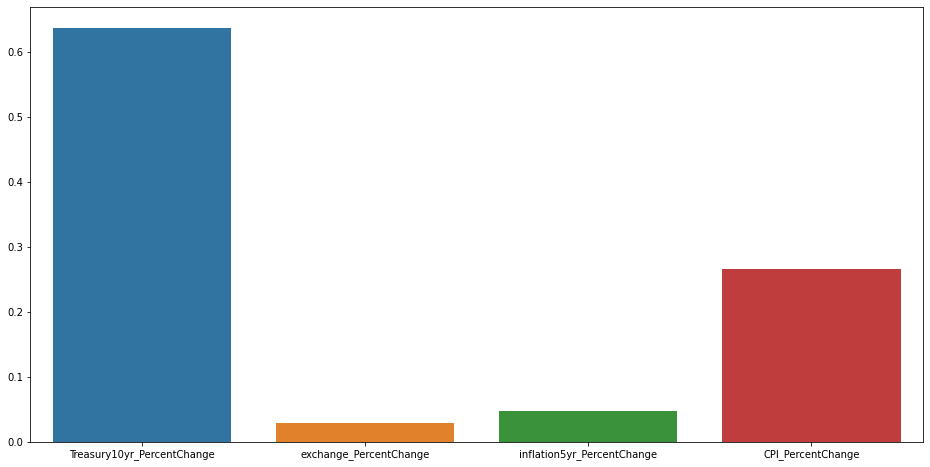

In [43]:
#permutation importance
plt.figure(figsize = (16,8))
sns.barplot(train_X.columns, permutation_importance(xgb1, train_X, train_y1)['importances_mean'])

### Value Stock

In [44]:
xgb2 = GradientBoostingRegressor(n_estimators=100, 
                                random_state = 2, 
                                min_impurity_decrease=0.0001, 
                                min_samples_split=2, 
                                max_depth = 2)
cv = cross_val_score(xgb1, train_X, train_y2, scoring = 'neg_mean_squared_error')
print(np.mean(-cv))

0.0001731433105622219


In [45]:
xgb2.fit(train_X, train_y2)
print("Training Score: ", xgb2.score(train_X, train_y2))
predictions = xgb2.predict(test_X)
print("R^2 Score: {}".format(r2_score(test_y2, predictions)))
print("MSE: {}".format(mean_squared_error(test_y2, predictions)))

Training Score:  0.8081902869036519
R^2 Score: 0.305323655598688
MSE: 0.00012821706683048946


/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

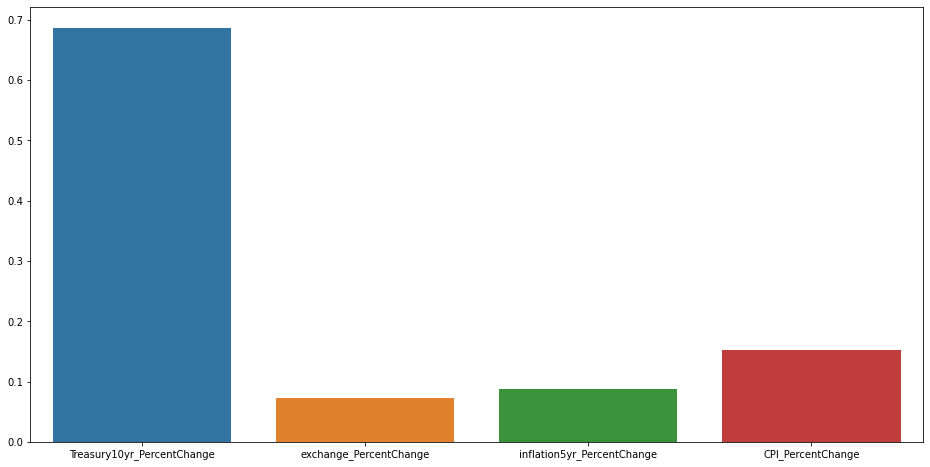

In [46]:
#importance based on r2
plt.figure(figsize = (16,8))
sns.barplot(train_X.columns, xgb2.feature_importances_)

/Users/lucheng/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

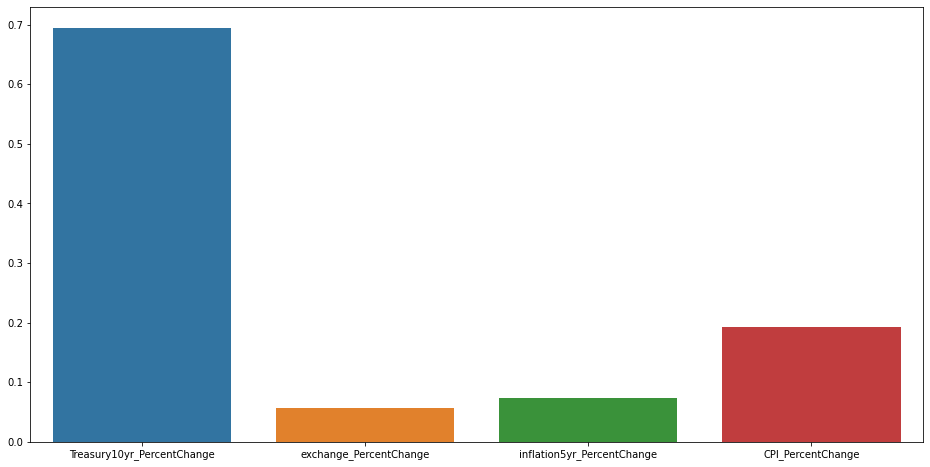

In [47]:
#permutation importance
plt.figure(figsize = (16,8))
sns.barplot(train_X.columns, permutation_importance(xgb2, train_X, train_y2)['importances_mean'])